In [80]:
with open('D:\HW\Jaar3\Blok2\Modelering\LLM.txt','r') as file:
    lines = file.readlines()
data = []
for line in lines:
    if len(line.strip().split(' ')) > 10:
        data.append(''.join(line.strip()))

print(len(data))

59


In [81]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import string

def preprocess_sentence(text):
    stop_words = set(stopwords.words('english'))
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower().split()
    
    text = [token for token in text if token not in stop_words]
    return text


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bram\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [82]:
sentences = []
vocab = set()
for line in data:
    line_preprocessed = preprocess_sentence(line)
    sentences.append(line_preprocessed)
    for i in line_preprocessed:
        vocab.add(i)
print(sentences)
print(len(vocab))


[['kanker', 'medisch', 'latijn', 'neoplasma', 'malignum', 'kwaadaardig', 'nieuwgevormd', 'weefsel', 'een', 'ziekte', 'die', 'zich', 'als', 'volgt', 'uit'], ['er', 'zijn', 'cellen', 'die', 'zich', 'onbeheerst', 'vermenigvuldigen', 'en', 'dit', 'blijven', 'doen'], ['de', 'woekerende', 'cellen', 'breiden', 'zich', 'uit', 'omliggend', 'weefsel', 'en', 'richten', 'hier', 'schade', 'aan', 'invasieve', 'groei', 'infiltratie'], ['de', 'woekerende', 'cellen', 'verspreiden', 'zich', 'ook', 'naar', 'plaatsen', 'elders', 'het', 'lichaam', 'door', 'metastasering', 'uitzaaiing', 'via', 'de', 'lymfevaten', 'lymfogene', 'metastasering', 'via', 'het', 'bloed', 'hematogene', 'metastasering', 'de', 'verschillende', 'lichaamsholten', 'bijvoorbeeld', 'de', 'buikholte'], ['nagenoeg', 'alle', 'medische', 'specialismen', 'houden', 'zich', 'bezig', 'met', 'de', 'behandeling', 'van', 'kanker', 'maar', 'met', 'name', 'medisch', 'specialisten', 'de', 'oncologie', 'en', 'de', 'radiotherapie', '2008', 'kanker', 'ne

In [83]:
import numpy as np
def create_pairs(sentences, w_size):
    X = []
    y = []

    for sentence in sentences:
        for i, w in enumerate(sentence):
            # Bepaal het venster
            start_idx = max(i - w_size, 0)
            end_idx = min(i + w_size + 1, len(sentence))

            # Contextwoorden (exclusief het target-woord zelf)
            context = sentence[start_idx:i] + sentence[i+1:end_idx]

            # Voeg context en target toe aan de output
            X.append(context)
            y.append(w)
    X = np.array(X, dtype=object)
    y = np.array(y, dtype=object)
    return X, y

In [124]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

X, y = create_pairs(sentences, 2)

def prepare_train_test_data(X, y, test_size=0.2, random_state=42):
    X_combined = [" ".join(context) for context in X]

    vectorizer_X = CountVectorizer(max_features=1000)
    vectorizer_y = CountVectorizer()

    X_sparse = vectorizer_X.fit_transform(X_combined)
    y_sparse = vectorizer_y.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X_sparse, y_sparse, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train, y_test

from sklearn.neural_network import MLPClassifier

def train_mlp_classifier(X_train, y_train, hidden_layer_sizes=(100,), random_state=42):
    model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, random_state=random_state, max_iter=500)
    
    y_train = np.asarray(y_train)
    
    model.fit(X_train, y_train)
    return model


In [125]:
X_train, X_test, y_train, y_test = prepare_train_test_data(X, y)

y_train_encoded = np.argmax(y_train, axis=1)
y_test_encoded = np.argmax(y_test, axis=1)

X_train = X_train.toarray() if isinstance(X_train, np.matrix) else X_train
X_test = X_test.toarray() if isinstance(X_test, np.matrix) else X_test
y_train_encoded = np.asarray(y_train_encoded)
y_test_encoded = np.asarray(y_test_encoded)

mlp_model = train_mlp_classifier(X_train, y_train_encoded)

train_accuracy = mlp_model.score(X_train, y_train_encoded)
test_accuracy = mlp_model.score(X_test, y_test_encoded)

print("Trainingsnauwkeurigheid:", train_accuracy)
print("Testnauwkeurigheid:", test_accuracy)


C:\Users\Bram\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1101: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trainingsnauwkeurigheid: 0.9990407673860912
Testnauwkeurigheid: 0.07854406130268199


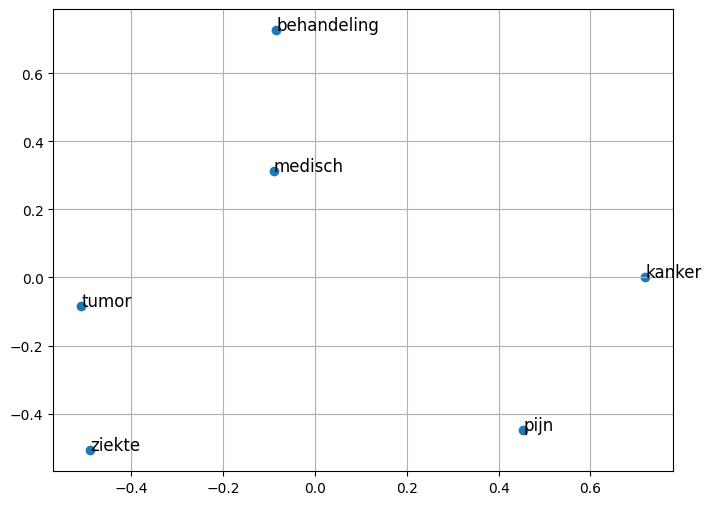

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

input_to_hidden_weights = mlp_model.coefs_[0]
word_vector = {}

for idx, word in enumerate(vocab):
    word_vector[word] = input_to_hidden_weights[idx]

for word in word_vector:
    word_vector[word] = word_vector[word] / np.linalg.norm(word_vector[word])

#print(word_vector['kanker'])


selected_words = ['kanker', 'tumor', 'ziekte', 'medisch', 'behandeling', 'pijn']
word_vectors = np.array([word_vector[word] for word in selected_words])

pca = PCA(n_components=2)
pca_result = pca.fit_transform(word_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1])

for i, word in enumerate(selected_words):
    plt.text(pca_result[i, 0], pca_result[i, 1], word, fontsize=12)

plt.grid(True)
plt.show()
